# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [1]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

/home/victorvj/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Stock("AAPL").get_df_financials()

,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,InterestExpenseNonOperating,InterestIncomeNonOperating,OperatingIncome,OperatingExpense,ResearchAndDevelopment,SellingGeneralAndAdministration,GrossProfit,CostOfRevenue,TotalRevenue,OperatingRevenue
0,AAPL,Apple Inc.,2025-06-30,0,Technology,Consumer Electronics,NaN,0.0,0.164,3.103200e+10,...,NaN,NaN,2.820200e+10,1.551600e+10,8.866000e+09,6.650000e+09,4.371800e+10,5.031800e+10,9.403600e+10,9.403600e+10
0,AAPL,Apple Inc.,2025-03-31,1,Technology,Consumer Electronics,-0.075141,0.0,0.155,3.225000e+10,...,NaN,NaN,2.958900e+10,1.527800e+10,8.550000e+09,6.728000e+09,4.486700e+10,5.049200e+10,9.535900e+10,9.535900e+10
0,AAPL,Apple Inc.,2024-12-31,2,Technology,Consumer Electronics,-0.107757,0.0,0.147,4.591200e+10,...,NaN,NaN,4.283200e+10,1.544300e+10,8.268000e+09,7.175000e+09,5.827500e+10,6.602500e+10,1.243000e+11,1.243000e+11
0,AAPL,Apple Inc.,2024-09-30,3,Technology,Consumer Electronics,0.083594,0.0,0.241,1.346610e+11,...,NaN,NaN,1.232160e+11,5.746700e+10,3.137000e+10,2.609700e+10,1.806830e+11,2.103520e+11,3.910350e+11,3.910350e+11
0,AAPL,Apple Inc.,2024-06-30,4,Technology,Consumer Electronics,0.082773,0.0,0.159,2.820200e+10,...,NaN,NaN,2.535200e+10,1.432600e+10,8.006000e+09,6.320000e+09,3.967800e+10,4.609900e+10,8.577700e+10,8.577700e+10
0,AAPL,Apple Inc.,2023-09-30,5,Technology,Consumer Electronics,0.126007,0.0,0.147,1.258200e+11,...,3.933000e+09,3.750000e+09,1.143010e+11,5.484700e+10,2.991500e+10,2.493200e+10,1.691480e+11,2.141370e+11,3.832850e+11,3.832850e+11
0,AAPL,Apple Inc.,2022-09-30,6,Technology,Consumer Electronics,-0.058281,0.0,0.162,1.305410e+11,...,2.931000e+09,2.825000e+09,1.194370e+11,5.134500e+10,2.625100e+10,2.509400e+10,1.707820e+11,2.235460e+11,3.943280e+11,3.943280e+11
0,AAPL,Apple Inc.,2021-09-30,7,Technology,Consumer Electronics,0.261202,0.0,0.133,1.231360e+11,...,2.645000e+09,2.843000e+09,1.089490e+11,4.388700e+10,2.191400e+10,2.197300e+10,1.528360e+11,2.129810e+11,3.658170e+11,3.658170e+11


### Variables

In [4]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
outlier = 3
tree_amount = int(input("Tree amount:"))
if tree_amount:
    train_new_model = True
else:
    train_new_model = False
if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

In [5]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()
symbols = pd.Series(symbols).unique()

## Data Preparation

#### Download annual financial data

In [6]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            if ticker_df.isna().sum().sum() < round(29 * minimum_feature_threshold):
                if symbol not in filtered_pd["Ticker"].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{"Ticker": symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd["Ticker"].tolist():
                    filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                    if debugging:
                        print(f"Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(29 * minimum_feature_threshold)}")
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

### Short visualisation

In [7]:
if debugging:
    display(df)

,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,GainOnSaleOfBusiness,NetIncomeExtraordinary,InsuranceAndClaims,OccupancyAndEquipment,OtherNonInterestExpense,ProfessionalExpenseAndContractServicesExpense,ProvisionForDoubtfulAccounts,SecuritiesAmortization,DepletionIncomeStatement,ExciseTaxes
0,BAESY,BAE Systems PLC,2024-12-31,0.0,Industrials,Aerospace & Defense,NaN,-1.746998e+06,0.124786,3.986000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAESY,BAE Systems PLC,2023-12-31,1.0,Industrials,Aerospace & Defense,0.216240,-4.862339e+07,0.165950,3.740000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAESY,BAE Systems PLC,2022-12-31,2.0,Industrials,Aerospace & Defense,0.171293,7.744344e+07,0.158371,2.570000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAESY,BAE Systems PLC,2021-12-31,3.0,Industrials,Aerospace & Defense,0.257805,2.160000e+07,0.180000,3.005000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CARL-B.CO,Carlsberg B A/S,2024-12-31,0.0,Consumer Defensive,Beverages - Brewers,NaN,-9.900000e+07,0.198000,1.629700e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5911,FM.TO,FIRST QUANTUM MINERALS LTD,2024-09-30,3.0,Basic Materials,Copper,0.010846,-4.050000e+06,0.150000,5.230000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5912,FM.TO,FIRST QUANTUM MINERALS LTD,2024-06-30,4.0,Basic Materials,Copper,0.054535,-1.095000e+07,0.150000,3.560000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5913,FM.TO,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,Basic Materials,Copper,0.317647,-4.064000e+08,0.400000,2.292000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5914,FM.TO,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,Basic Materials,Copper,0.098268,4.048000e+07,0.220000,3.099000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [8]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [9]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,GainOnSaleOfBusiness,NetIncomeExtraordinary,InsuranceAndClaims,OccupancyAndEquipment,OtherNonInterestExpense,ProfessionalExpenseAndContractServicesExpense,ProvisionForDoubtfulAccounts,SecuritiesAmortization,DepletionIncomeStatement,ExciseTaxes
0,73,BAE Systems PLC,2024-12-31,0.0,7,1,NaN,0.022134,-0.678496,0.055314,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
1,136,Carlsberg B A/S,2024-12-31,0.0,3,13,NaN,-0.022490,0.119893,0.853640,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
2,475,ISS A/S,2024-12-31,0.0,7,108,NaN,0.023945,0.141703,0.160754,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
3,635,"Netflix, Inc.",2025-06-30,0.0,1,40,NaN,0.022936,-0.512589,0.297867,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4,284,Equinor ASA,2025-06-30,0.0,4,77,NaN,0.031617,0.359800,0.409700,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,112,BUNZL PLC ORD 32 1/7P,2024-12-31,0.0,3,44,NaN,0.017010,0.754938,-0.120200,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
957,935,WASTE CONNECTIONS INC,2025-06-30,0.0,7,125,NaN,0.022466,0.731569,-0.152351,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
958,200,CONSTELLATION SOFTWARE INC.,2025-06-30,0.0,9,105,NaN,0.014745,-0.403541,-0.158031,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
959,515,LOBLAW CO,2025-06-30,0.0,3,48,NaN,0.022936,0.827641,-0.083652,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0


Test Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,GainOnSaleOfBusiness,NetIncomeExtraordinary,InsuranceAndClaims,OccupancyAndEquipment,OtherNonInterestExpense,ProfessionalExpenseAndContractServicesExpense,ProvisionForDoubtfulAccounts,SecuritiesAmortization,DepletionIncomeStatement,ExciseTaxes
0,73,BAE Systems PLC,2023-12-31,1.0,7,1,0.216240,0.000625,-0.229608,0.039362,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
1,136,Carlsberg B A/S,2023-12-31,1.0,3,13,0.154066,-0.005162,0.021749,0.791776,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
2,475,ISS A/S,2023-12-31,1.0,7,108,-0.018735,0.028261,0.348895,0.090980,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
3,635,"Netflix, Inc.",2025-03-31,1.0,1,40,0.436018,0.022936,-0.948784,0.270285,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4,284,Equinor ASA,2025-03-31,1.0,4,77,-0.034369,0.023844,0.359800,0.543803,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,112,BUNZL PLC ORD 32 1/7P,2023-12-31,1.0,3,44,-0.046904,0.019346,0.651822,-0.124635,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
937,935,WASTE CONNECTIONS INC,2025-03-31,1.0,7,125,-0.091643,0.022262,0.447039,-0.158405,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
938,200,CONSTELLATION SOFTWARE INC.,2025-03-31,1.0,9,105,0.095941,0.017182,2.104579,-0.161598,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
939,515,LOBLAW CO,2025-03-31,1.0,3,48,0.119805,0.022936,0.828710,-0.098113,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0


Training Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,...,GainOnSaleOfBusiness,NetIncomeExtraordinary,InsuranceAndClaims,OccupancyAndEquipment,OtherNonInterestExpense,ProfessionalExpenseAndContractServicesExpense,ProvisionForDoubtfulAccounts,SecuritiesAmortization,DepletionIncomeStatement,ExciseTaxes
0,73,BAE Systems PLC,2022-12-31,2.0,7,1,0.171293,0.058470,-0.312256,-0.036509,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
1,73,BAE Systems PLC,2021-12-31,3.0,7,1,0.257805,0.032847,-0.076395,-0.008300,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
2,136,Carlsberg B A/S,2022-12-31,2.0,3,13,0.183250,-0.034968,-0.087300,0.759872,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
3,136,Carlsberg B A/S,2021-12-31,3.0,3,13,-0.242843,0.130973,0.207132,0.716878,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4,475,ISS A/S,2022-12-31,2.0,7,108,-0.052274,0.038227,-0.283587,0.072174,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,330,FIRST QUANTUM MINERALS LTD,2024-09-30,3.0,0,28,0.010846,0.021077,-0.403541,-0.169250,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4010,330,FIRST QUANTUM MINERALS LTD,2024-06-30,4.0,0,28,0.054535,0.017911,-0.403541,-0.180079,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4011,330,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,0,28,0.317647,-0.163537,2.322677,-0.054536,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4012,330,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,0,28,0.098268,0.041509,0.359800,-0.002205,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0


### Labeling

In [10]:
training_columns = train_data.columns.drop(["Name", "Sector", "Industry", "Date", '3M Future Change'])
label_columns = ['3M Future Change']
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


,Ticker,Earn Index,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,TotalUnusualItems,TotalUnusualItemsExcludingGoodwill,NetIncomeFromContinuingOperationNetMinorityInterest,ReconciledDepreciation,ReconciledCostOfRevenue,...,GainOnSaleOfBusiness,NetIncomeExtraordinary,InsuranceAndClaims,OccupancyAndEquipment,OtherNonInterestExpense,ProfessionalExpenseAndContractServicesExpense,ProvisionForDoubtfulAccounts,SecuritiesAmortization,DepletionIncomeStatement,ExciseTaxes
0,73,0.0,0.022134,-0.678496,0.055314,4.119086e-02,0.041682,-0.031057,-0.026873,0.151139,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
1,136,0.0,-0.022490,0.119893,0.853640,-2.156143e-02,-0.021069,0.007166,0.105406,1.911563,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
2,475,0.0,0.023945,0.141703,0.160754,4.441885e-02,0.044910,-0.025778,-0.011410,0.063748,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
3,635,0.0,0.022936,-0.512589,0.297867,-7.696147e-18,0.000000,-0.021939,0.086967,-0.058671,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4,284,0.0,0.031617,0.359800,0.409700,5.410285e-02,0.054594,-0.036071,0.067434,0.546015,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,112,0.0,0.017010,0.754938,-0.120200,3.649089e-02,0.036982,-0.042407,-0.055097,0.112008,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
957,935,0.0,0.022466,0.731569,-0.152351,4.247818e-02,0.042969,-0.044045,-0.058175,-0.278121,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
958,200,0.0,0.014745,-0.403541,-0.158031,2.763326e-02,0.028125,-0.045872,-0.057034,-0.338494,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
959,515,0.0,0.022936,0.827641,-0.083652,-7.696147e-18,0.000000,-0.040741,-0.046403,0.192323,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0


X_test:


,Ticker,Earn Index,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,TotalUnusualItems,TotalUnusualItemsExcludingGoodwill,NetIncomeFromContinuingOperationNetMinorityInterest,ReconciledDepreciation,ReconciledCostOfRevenue,...,GainOnSaleOfBusiness,NetIncomeExtraordinary,InsuranceAndClaims,OccupancyAndEquipment,OtherNonInterestExpense,ProfessionalExpenseAndContractServicesExpense,ProvisionForDoubtfulAccounts,SecuritiesAmortization,DepletionIncomeStatement,ExciseTaxes
0,73,1.0,0.000625,-0.229608,0.039362,5.166397e-03,0.005658,-0.031829,-0.039074,0.083503,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
1,136,1.0,-0.005162,0.021749,0.791776,1.163679e-03,0.001656,0.007961,0.093487,1.918371,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
2,475,1.0,0.028261,0.348895,0.090980,4.984189e-02,0.050333,-0.031252,-0.011612,0.052810,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
3,635,1.0,0.022936,-0.948784,0.270285,-7.696147e-18,0.000000,-0.023771,0.086608,-0.062140,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4,284,1.0,0.023844,0.359800,0.543803,4.416061e-02,0.044652,-0.025825,0.022455,0.634856,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,112,1.0,0.019346,0.651822,-0.124635,3.890543e-02,0.039397,-0.042205,-0.056760,0.124587,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
937,935,1.0,0.022262,0.447039,-0.158405,4.216700e-02,0.042658,-0.044425,-0.058888,-0.283781,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
938,200,1.0,0.017182,2.104579,-0.161598,3.873758e-02,0.039229,-0.045412,-0.057759,-0.339443,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
939,515,1.0,0.022936,0.828710,-0.098113,-7.696147e-18,0.000000,-0.042386,-0.042175,0.175414,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0


y_test:


,3M Future Change
0,0.216240
1,0.154066
2,-0.018735
3,0.436018
4,-0.034369
...,...
936,-0.046904
937,-0.091643
938,0.095941
939,0.119805


X_train:


,Ticker,Earn Index,TaxEffectOfUnusualItems,TaxRateForCalcs,NormalizedEBITDA,TotalUnusualItems,TotalUnusualItemsExcludingGoodwill,NetIncomeFromContinuingOperationNetMinorityInterest,ReconciledDepreciation,ReconciledCostOfRevenue,...,GainOnSaleOfBusiness,NetIncomeExtraordinary,InsuranceAndClaims,OccupancyAndEquipment,OtherNonInterestExpense,ProfessionalExpenseAndContractServicesExpense,ProvisionForDoubtfulAccounts,SecuritiesAmortization,DepletionIncomeStatement,ExciseTaxes
0,73,2.0,0.058470,-0.312256,-0.036509,0.106138,0.106629,-0.033903,-0.039799,0.040031,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
1,73,3.0,0.032847,-0.076395,-0.008300,0.058493,0.058984,-0.032601,-0.042336,0.032609,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
2,136,2.0,-0.034968,-0.087300,0.759872,0.042353,-0.047538,0.008367,0.098037,1.775789,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
3,136,3.0,0.130973,0.207132,0.716878,0.190583,0.191072,0.009287,0.100091,1.403570,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4,475,2.0,0.038227,-0.283587,0.072174,0.069726,0.070217,-0.030425,-0.009478,0.006046,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,330,3.0,0.021077,-0.403541,-0.169250,0.039512,0.040004,-0.045466,-0.064161,-0.309922,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4010,330,4.0,0.017911,-0.403541,-0.180079,0.033573,0.034064,-0.046667,-0.064604,-0.305737,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4011,330,5.0,-0.163537,2.322677,-0.054536,-0.088187,-0.087694,-0.053747,-0.025424,-0.067673,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0
4012,330,6.0,0.041509,0.359800,-0.002205,0.066757,0.067248,-0.038246,-0.021034,-0.053052,...,0.0,0.0,-8.181354e-17,1.561741e-16,0.0,0.0,-3.570552e-16,0.0,0.0,0.0


y_train:


,3M Future Change
0,0.171293
1,0.257805
2,0.183250
3,-0.242843
4,-0.052274
...,...
4009,0.010846
4010,0.054535
4011,0.317647
4012,0.098268


## Model Training

In [11]:
if train_new_model:
    model = RandomForestRegressor(
        n_estimators=tree_amount,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   32.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  4.1min finished


## Testing and benchmarking

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    0.2s finished


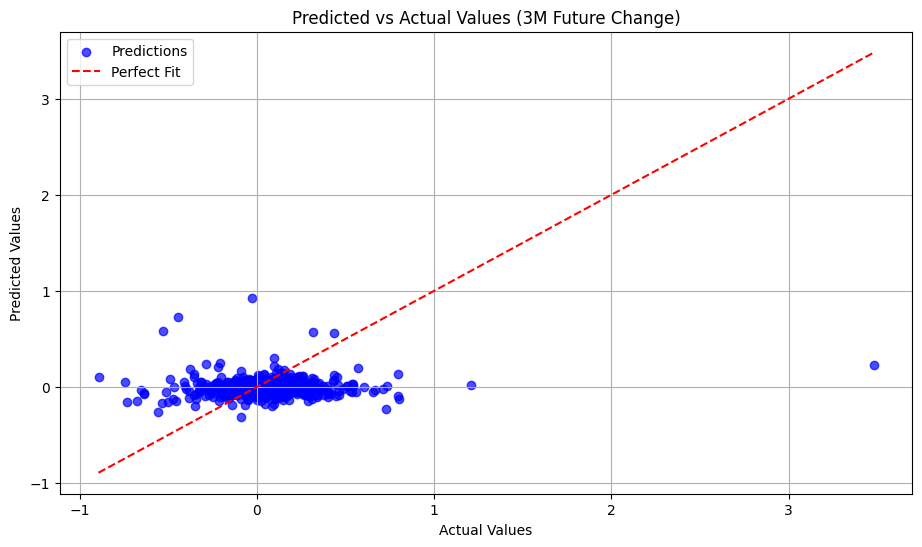

3M Future Change - R²: -0.0909
3M Future Change - MSE: 0.0524
3M Future Change - MAE: 0.1367

Overall Scores:
Mean - R²: -0.0909
Mean - MSE: 0.0524
Mean - MAE: 0.1367


In [12]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change']):
        y_test_actual = y_test[target].values
        if getattr(y_test_pred, "ndim", 1) == 1:
            y_test_pred_target = y_test_pred
        else:
            y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    # Overall metrics (single target)
    overall_pred = y_test_pred if getattr(y_test_pred, "ndim", 1) == 1 else y_test_pred[:, 0]
    mae = mean_absolute_error(y_test['3M Future Change'].values, overall_pred)
    mse = mean_squared_error(y_test['3M Future Change'].values, overall_pred)
    r2 = r2_score(y_test['3M Future Change'].values, overall_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [13]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

NameError: name 'iterations' is not defined

## Predictions on latest data

In [ ]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.019355189464046


In [ ]:
df_raw = pd.read_csv('../data/model_results/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ExciseTaxes


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
